# Самостоятельная работа

In [1]:
from queue import LifoQueue, PriorityQueue
from PIL import Image
import numpy as np
from random import choice
from typing import List
import functools
import time

## Задание №1

Реализуйте программу для генерации произвольного лабиринта размером N x M, размер
задается пользователем. Выберите структуру данных для хранения лабиринта в памяти и
способ генерации лабиринта. В лабиринте должны быть вход и выход. Сгенерированный
лабиринт должен быть отображен графически (например, при помощи tkinter, PyQt, pygame
или т.п.).
Продемонстрируйте несколько картинок получившихся лабиринтов разных размеров.

In [2]:
def generate_maze(width, height):
    maze = Image.new('RGB', (2 * width + 1, 2 * height + 1), 'black')
    pixels = maze.load()

    pixels[1, 0] = (255, 255, 255)
    pixels[-2, -1] = (255, 255, 255)
    
    stack = LifoQueue()
    cells = np.zeros((width, height))
    cells[0, 0] = 1
    stack.put((0, 0))

    while not stack.empty():
        x, y = stack.get()

        adjacents = []
        if x > 0 and cells[x - 1, y] == 0:
            adjacents.append((x - 1, y))
        if x < width - 1 and cells[x + 1, y] == 0:
            adjacents.append((x + 1, y))
        if y > 0 and cells[x, y - 1] == 0:
            adjacents.append((x, y - 1))
        if y < height - 1 and cells[x, y + 1] == 0:
            adjacents.append((x, y + 1))

        if adjacents:
            stack.put((x, y))

            neighbour = choice(adjacents)
            neighbour_on_img = (neighbour[0]*2 + 1, neighbour[1]*2 + 1)
            current_on_img = (x*2 + 1, y*2 + 1)
            wall_to_remove = (neighbour[0] + x + 1, neighbour[1] + y + 1)

            pixels[neighbour_on_img] = (255, 255, 255)
            pixels[current_on_img] = (255, 255, 255)
            pixels[wall_to_remove] = (255, 255, 255)

            cells[neighbour] = 1
            stack.put(neighbour)

    return maze

width = 200
height = 200


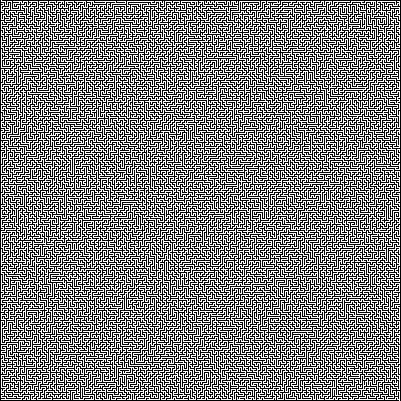

In [3]:
width = int(input('width = '))
height = int(input('height = '))

size = (width, height)
maze = generate_maze(*size)
maze.save('maze.png')
maze

## Задание №2

Реализуйте один из алгоритмов для обхода лабиринта (волновой, А*, Дейкстры, БеллманаФорда или т.п.). Найдите при помощи него путь от входа до выхода. Используя программу
из предыдущего задания, визуализируйте работу вашего алгоритма и итоговый найденный
путь.
Продемонстрируйте несколько картинок для различных лабиринтов.

In [4]:
PATH = (255, 255, 255)
WALL = (0, 0, 0)

class Node:

    def __init__(self, coords):
        self.coords = coords
        self.previous = None
        self.distance = None
        self.adjacency_list = {}
    
    def link(self, node, weight=1):
        self.adjacency_list[node] = weight
        node.adjacency_list[self] = weight

    def __repr__(self):
        return f'Node({self.coords!r})'


def nodes_from_maze(image) -> (Node, Node, List[Node]):

    nodes = {}
    start_node = None
    finish_node = None
    maze = image.convert('RGB')
    pixels = maze.load()

    for y in range(maze.height):

        last_node = None
        weight_counter = 0

        for x in range(maze.width):
            if pixels[x, y] == PATH:
                left = pixels[x-1, y] if x > 0 else None
                right = pixels[x+1, y] if x < maze.width-1 else None
                top = pixels[x, y-1] if y > 0 else None
                bottom = pixels[x, y+1] if y < maze.height-1 else None

                horizontal_paths = (left == PATH or right == PATH)
                vertical_paths = (top == PATH or bottom == PATH)
                turning_point = horizontal_paths and vertical_paths
                dead_end = [left, right, top, bottom].count(PATH) == 1

                if turning_point or dead_end:
                    node = Node((x, y))

                    if not start_node and (x == 0 or y == 0):
                        start_node = node
                    elif not finish_node and (x == maze.width-1 or y == maze.width-1):
                        finish_node = node

                    if last_node:
                        node.link(last_node, weight_counter)
                        weight_counter = 0

                    last_node = node
                    nodes[(x, y)] = node

                weight_counter += 1

            else:
                last_node = None
                weight_counter = 0

    for x in range(maze.width):

        last_node = None
        weight_counter = 0

        for y in range(maze.height):
            if pixels[x, y] == PATH:
                if node := nodes.get((x, y)):
                    if last_node:
                        node.link(last_node, weight_counter)
                        weight_counter = 0
                    last_node = node
                weight_counter += 1
            else:
                last_node = None
                weight_counter = 0

    nodes = list(nodes.values())
    return start_node, finish_node, nodes

In [5]:
@functools.total_ordering
class PriorityItem:

    def __init__(self, priority, item):
        self.priority = priority
        self.item = item

    def __eq__(self, other):
        return self.priority == other.priority

    def __lt__(self, other):
        return self.priority < other.priority


def run_dijkstra_algorithm(start_node, nodes) -> None:

    queue = PriorityQueue()

    start_node.distance = 0

    current_node = None
    shortest_path = [start_node]

    queue.put(PriorityItem(0, start_node))

    while not queue.empty():

        current_node = queue.get().item

        for node, weight in current_node.adjacency_list.items():
            if node not in shortest_path:
                if node.distance and current_node.distance + weight >= node.distance:
                    continue
                node.distance = current_node.distance + weight
                node.previous = current_node
                queue.put(PriorityItem(node.distance, node))


def get_path_from_node(node: Node) -> List[Node]:

    path = []
    while node:
        path.append(node)
        node = node.previous
    return path


def colour_path(image, path) -> None:

    start_node = path[-1]
    finish_node = path[0]

    pixels = image.load()

    red_fade = np.linspace(255, 0, finish_node.distance + 1).astype(int)
    blue_fade = np.linspace(0, 255, finish_node.distance + 1).astype(int)
    step = 0

    for node1, node2 in zip(path[:-1], path[1:]):
        x1, y1 = node1.coords
        x2, y2 = node2.coords
        distance = node1.distance - node2.distance
        x_change = np.linspace(x1, x2, distance + 1)[:-1]
        y_change = np.linspace(y1, y2, distance + 1)[:-1]

        for path_x, path_y in zip(x_change, y_change):
            pixels[path_x, path_y] = (red_fade[step], blue_fade[step], 0)
            step += 1

    pixels[start_node.coords] = (red_fade[step], blue_fade[step], 0)


def solve_image(file_path) -> None:

    import os
    image = Image.open(file_path)
    start_node, finish_node, nodes = nodes_from_maze(image)
    run_dijkstra_algorithm(start_node, nodes)
    path = get_path_from_node(finish_node)
    colour_path(image, path)
    image.save(os.path.join(os.path.dirname(file_path), "solved_%s" % os.path.basename(file_path)))

In [6]:
start = time.time()
solve_image('maze.png')
end = time.time() - start
print('Time taken:', end)

Time taken: 0.8693225383758545


![](./solved_maze.png)